In [5]:
import datetime
import os.path as osp
import platform

import matplotlib
import mplhep
import numpy as np
import torch
import torch_geometric
from pyg_ssl.args import parse_args
from pyg_ssl.mlpf import MLPF
from pyg_ssl.training_mlpf import training_loop_mlpf
from pyg_ssl.training_VICReg import training_loop_VICReg
from pyg_ssl.utils import CLUSTERS_X, TRACKS_X, data_split, load_VICReg, save_MLPF, save_VICReg, distinguish_PFelements, combine_PFelements
from pyg_ssl.VICReg import DECODER, ENCODER

matplotlib.use("Agg")
mplhep.style.use(mplhep.styles.CMS)

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


In [6]:
# load the clic dataset
data_VICReg_train, data_VICReg_valid, data_mlpf_train, data_mlpf_valid, data_test_qcd, data_test_ttbar = data_split(
    "/pfclicvol/data/clic_edm4hep", "quick"
)

Will use data split mode `quick`
Will use 25843 events to train VICReg
Will use 2871 events to validate VICReg
Will use 6461 events to train MLPF
Will use 718 events to validate MLPF


In [51]:
embedding_dim_VICReg = 256
width_encoder = 256 
num_convs = 3
expand_dim = 256
width_decoder = 256

encoder_model_kwargs = {
    "embedding_dim": embedding_dim_VICReg,
    "width": width_encoder,
    "num_convs": num_convs,
    "space_dim": 4,
    "propagate_dim": 22,
    "k": 32,
}

decoder_model_kwargs = {
    "input_dim": embedding_dim_VICReg,
    "output_dim": expand_dim,
    "width": width_decoder,
}

encoder = ENCODER(**encoder_model_kwargs).to(device)
decoder = DECODER(**decoder_model_kwargs).to(device)

print("Encoder", encoder)
print("Decoder", decoder)

Encoder ENCODER(
  (nn1): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv): ModuleList(
    (0): GravNetConv(256, 256, k=32)
    (1): GravNetConv(256, 256, k=32)
    (2): GravNetConv(256, 256, k=32)
  )
)
Decoder DECODER(
  (expander): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features

In [52]:
import json
import pickle as pkl
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


# VICReg loss function
def criterion(x, y, device="cuda", lmbd=25, epsilon=1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T @ yNorm) / bs
    cross_loss = (crossCorMat * lmbd - torch.eye(emb, device=torch.device(device)) * lmbd).pow(2).sum()

    return var_loss, invar_loss, cross_loss


@torch.no_grad()
def validation_run(
    device,
    encoder,
    decoder,
    train_loader,
    valid_loader,
    lmbd,
    u,
    v,
):
    with torch.no_grad():
        optimizer = None
        ret = train(
            device,
            encoder,
            decoder,
            train_loader,
            valid_loader,
            optimizer,
            lmbd,
            u,
            v,
        )
    return ret


def train(
    device,
    encoder,
    decoder,
    train_loader,
    valid_loader,
    optimizer,
    lmbd,
    u,
    v,
):

    is_train = not (optimizer is None)

    if is_train:
        print("---->Initiating a training run")
        encoder.train()
        decoder.train()
        loader = train_loader
    else:
        print("---->Initiating a validation run")
        encoder.eval()
        decoder.eval()
        loader = valid_loader

    # initialize loss counters
    losses = 0.0
    var_losses, invar_losses, cross_losses = 0.0, 0.0, 0.0

    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        # make transformation
        tracks, clusters = distinguish_PFelements(batch.to(device))

        # ENCODE
        embedding_tracks, embedding_clusters = encoder(tracks, clusters)
        # DECODE
        out_tracks, out_clusters = decoder(embedding_tracks, embedding_clusters)

        # POOLING
        pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
        pooled_clusters = global_mean_pool(out_clusters, clusters.batch)
        
        # compute loss
        var_loss, invar_loss, cross_loss = criterion(pooled_tracks, pooled_clusters, device, lmbd)
        loss = u * var_loss + v * invar_loss + cross_loss

        # update parameters
        if is_train:
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

        losses += loss.detach()
        var_losses += var_loss.detach()
        invar_losses += invar_loss.detach()
        cross_losses += cross_loss.detach()

    losses = losses.cpu().item() / (len(loader))
    var_losses = var_losses.cpu().item() / (len(loader))
    invar_losses = invar_losses.cpu().item() / (len(loader))
    cross_losses = cross_losses.cpu().item() / (len(loader))

    return losses, var_losses, invar_losses, cross_losses

In [53]:
batch_size_VICReg = 1000
train_loader = torch_geometric.loader.DataLoader(data_VICReg_train, batch_size_VICReg)
valid_loader = torch_geometric.loader.DataLoader(data_VICReg_valid, batch_size_VICReg)

In [54]:
import tqdm

lr = 1e-4
n_epochs = 100
lmbd = 0.1
u = 0.01
v = 0.01
patience = 50

optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

torch.cuda.empty_cache()

t0_initial = time.time()

losses_train_tot, losses_train_var, losses_train_invar, losses_train_cross = [], [], [], []
losses_valid_tot, losses_valid_var, losses_valid_invar, losses_valid_cross = [], [], [], []

best_val_loss_tot, best_val_loss_var, best_val_loss_invar, best_val_cross = 99999.9, 99999.9, 99999.9, 99999.9
stale_epochs = 0

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_var, losses_t_invar, losses_t_cross = train(
        device,
        encoder,
        decoder,
        train_loader,
        valid_loader,
        optimizer,
        lmbd,
        u,
        v,
    )

    losses_train_tot.append(losses_t_tot)
    losses_train_var.append(losses_t_var)
    losses_train_invar.append(losses_t_invar)
    losses_train_cross.append(losses_t_cross)

    # validation step
    losses_v_tot, losses_v_var, losses_v_invar, losses_v_cross = validation_run(
        device,
        encoder,
        decoder,
        train_loader,
        valid_loader,
        lmbd,
        u,
        v,
    )

    losses_valid_tot.append(losses_v_tot)
    losses_valid_var.append(losses_v_var)
    losses_valid_invar.append(losses_v_invar)
    losses_valid_cross.append(losses_v_cross)

    # save the lowest value of each component of the loss to print it on the legend of the loss plots
    if losses_v_var < best_val_loss_var:
        best_val_loss_var = losses_v_var
        best_train_loss_var = losses_t_var

    if losses_v_invar < best_val_loss_invar:
        best_val_loss_invar = losses_v_invar
        best_train_loss_invar = losses_t_invar

    if losses_v_cross < best_val_cross:
        best_val_loss_cross = losses_v_cross
        best_train_loss_cross = losses_t_cross

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0

    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=1 / 100 train_loss=4.6347 valid_loss=3.0957 stale=0 time=0.3m eta=30.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=2 / 100 train_loss=3.7514 valid_loss=3.0436 stale=0 time=0.3m eta=29.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=3 / 100 train_loss=3.4974 valid_loss=3.0262 stale=0 time=0.3m eta=29.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=4 / 100 train_loss=3.3871 valid_loss=3.0171 stale=0 time=0.31m eta=29.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=5 / 100 train_loss=3.3124 valid_loss=3.0131 stale=0 time=0.31m eta=29.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=6 / 100 train_loss=3.2705 valid_loss=3.0125 stale=0 time=0.31m eta=28.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=7 / 100 train_loss=3.248 valid_loss=3.0109 stale=0 time=0.31m eta=28.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=8 / 100 train_loss=3.1933 valid_loss=3.011 stale=1 time=0.31m eta=28.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=9 / 100 train_loss=3.1586 valid_loss=3.0132 stale=2 time=0.31m eta=27.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=10 / 100 train_loss=3.139 valid_loss=3.0187 stale=3 time=0.31m eta=27.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=11 / 100 train_loss=3.1092 valid_loss=3.0231 stale=4 time=0.31m eta=27.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=12 / 100 train_loss=3.091 valid_loss=3.0236 stale=5 time=0.31m eta=26.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=13 / 100 train_loss=3.0711 valid_loss=3.0295 stale=6 time=0.31m eta=26.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=14 / 100 train_loss=3.0685 valid_loss=3.03 stale=7 time=0.31m eta=26.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=15 / 100 train_loss=3.057 valid_loss=3.039 stale=8 time=0.31m eta=26.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=16 / 100 train_loss=3.0329 valid_loss=3.0442 stale=9 time=0.31m eta=25.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=17 / 100 train_loss=3.0123 valid_loss=3.0487 stale=10 time=0.31m eta=25.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch=18 / 100 train_loss=3.0034 valid_loss=3.0557 stale=11 time=0.31m eta=25.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=19 / 100 train_loss=2.9966 valid_loss=3.062 stale=12 time=0.31m eta=24.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=20 / 100 train_loss=2.977 valid_loss=3.068 stale=13 time=0.31m eta=24.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=21 / 100 train_loss=2.9751 valid_loss=3.0734 stale=14 time=0.31m eta=24.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=22 / 100 train_loss=2.9609 valid_loss=3.0774 stale=15 time=0.31m eta=23.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=23 / 100 train_loss=2.9483 valid_loss=3.0814 stale=16 time=0.31m eta=23.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=24 / 100 train_loss=2.9374 valid_loss=3.0869 stale=17 time=0.31m eta=23.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch=25 / 100 train_loss=2.9324 valid_loss=3.0894 stale=18 time=0.31m eta=23.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=26 / 100 train_loss=2.9232 valid_loss=3.0963 stale=19 time=0.31m eta=22.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=27 / 100 train_loss=2.9266 valid_loss=3.1012 stale=20 time=0.31m eta=22.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=28 / 100 train_loss=2.9139 valid_loss=3.1036 stale=21 time=0.31m eta=22.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=29 / 100 train_loss=2.9049 valid_loss=3.1089 stale=22 time=0.31m eta=21.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=30 / 100 train_loss=2.8999 valid_loss=3.1117 stale=23 time=0.31m eta=21.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=31 / 100 train_loss=2.8923 valid_loss=3.1173 stale=24 time=0.31m eta=21.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=32 / 100 train_loss=2.908 valid_loss=3.1181 stale=25 time=0.31m eta=20.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=33 / 100 train_loss=2.8854 valid_loss=3.1222 stale=26 time=0.31m eta=20.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=34 / 100 train_loss=2.8739 valid_loss=3.1234 stale=27 time=0.31m eta=20.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=35 / 100 train_loss=2.8708 valid_loss=3.1335 stale=28 time=0.31m eta=20.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=36 / 100 train_loss=2.8638 valid_loss=3.1335 stale=29 time=0.31m eta=19.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=37 / 100 train_loss=2.8567 valid_loss=3.1319 stale=30 time=0.31m eta=19.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=38 / 100 train_loss=2.8513 valid_loss=3.1327 stale=31 time=0.31m eta=19.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=39 / 100 train_loss=2.851 valid_loss=3.1335 stale=32 time=0.31m eta=18.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=40 / 100 train_loss=2.8582 valid_loss=3.1332 stale=33 time=0.31m eta=18.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=41 / 100 train_loss=2.8415 valid_loss=3.1343 stale=34 time=0.31m eta=18.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=42 / 100 train_loss=2.8352 valid_loss=3.1342 stale=35 time=0.31m eta=17.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=43 / 100 train_loss=2.8301 valid_loss=3.1375 stale=36 time=0.31m eta=17.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=44 / 100 train_loss=2.832 valid_loss=3.1381 stale=37 time=0.31m eta=17.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=45 / 100 train_loss=2.8265 valid_loss=3.1419 stale=38 time=0.31m eta=16.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=46 / 100 train_loss=2.8165 valid_loss=3.1411 stale=39 time=0.31m eta=16.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=47 / 100 train_loss=2.8163 valid_loss=3.1372 stale=40 time=0.31m eta=16.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=48 / 100 train_loss=2.811 valid_loss=3.134 stale=41 time=0.31m eta=16.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=49 / 100 train_loss=2.8089 valid_loss=3.1408 stale=42 time=0.31m eta=15.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=50 / 100 train_loss=2.8112 valid_loss=3.1368 stale=43 time=0.31m eta=15.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=51 / 100 train_loss=2.8026 valid_loss=3.1432 stale=44 time=0.31m eta=15.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=52 / 100 train_loss=2.7951 valid_loss=3.142 stale=45 time=0.31m eta=14.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=53 / 100 train_loss=2.7912 valid_loss=3.1394 stale=46 time=0.31m eta=14.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=54 / 100 train_loss=2.7882 valid_loss=3.1418 stale=47 time=0.31m eta=14.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=55 / 100 train_loss=2.7847 valid_loss=3.1397 stale=48 time=0.31m eta=13.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch=56 / 100 train_loss=2.7806 valid_loss=3.1359 stale=49 time=0.31m eta=13.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=57 / 100 train_loss=2.7773 valid_loss=3.1378 stale=50 time=0.31m eta=13.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

epoch=58 / 100 train_loss=2.7739 valid_loss=3.1388 stale=51 time=0.31m eta=12.9m
breaking due to stale epochs
----------------------------------------------------------
Done with training. Total training time is 17.816min


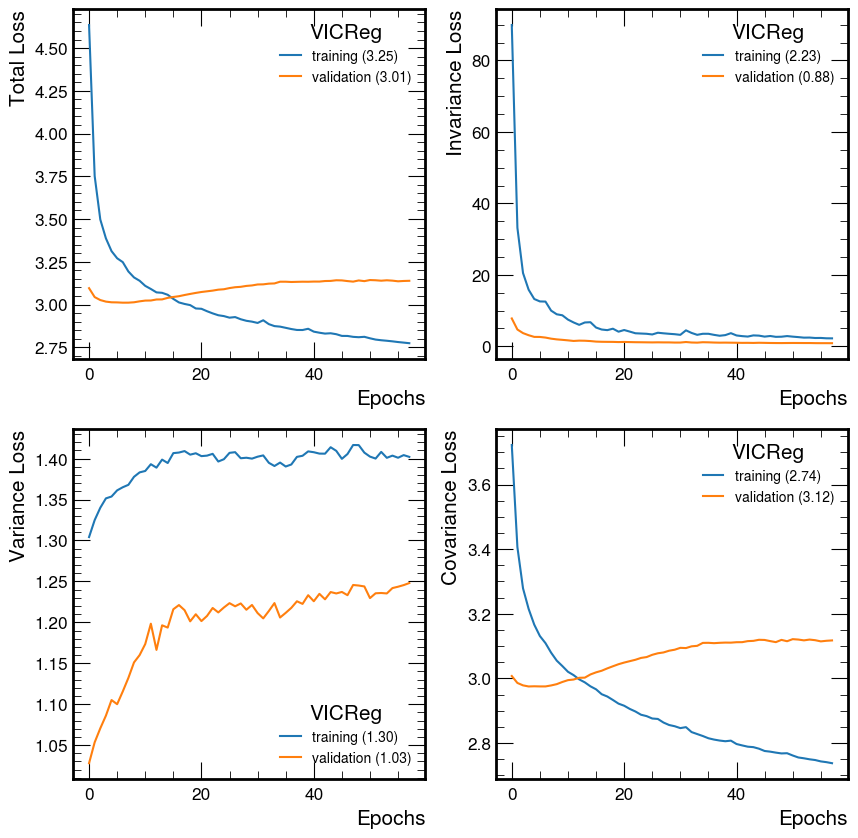

In [55]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax[0,0].plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Total Loss")
ax[0,0].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make variance loss plot
ax[1,0].plot(range(len(losses_train_var)), losses_train_var, label="training ({:.2f})".format(best_train_loss_var))
ax[1,0].plot(range(len(losses_valid_var)), losses_valid_var, label="validation ({:.2f})".format(best_val_loss_var))
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Variance Loss")
ax[1,0].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make invariance loss plot
ax[0,1].plot(range(len(losses_train_invar)), losses_train_invar, label="training ({:.2f})".format(best_train_loss_invar))
ax[0,1].plot(range(len(losses_valid_invar)), losses_valid_invar, label="validation ({:.2f})".format(best_val_loss_invar))
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Invariance Loss")
ax[0,1].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make covariance loss plot
ax[1,1].plot(range(len(losses_train_cross)), losses_train_cross, label="training ({:.2f})".format(best_train_loss_cross))
ax[1,1].plot(range(len(losses_valid_cross)), losses_valid_cross, label="validation ({:.2f})".format(best_val_loss_cross))
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Covariance Loss")
ax[1,1].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# MLPF

In [56]:
print("------> Progressing to MLPF trainings...")
print(f"Will use {len(data_mlpf_train)} events for train")
print(f"Will use {len(data_mlpf_valid)} events for valid")

train_loader = torch_geometric.loader.DataLoader(data_mlpf_train, 500)
valid_loader = torch_geometric.loader.DataLoader(data_mlpf_valid, 500)

input_ = max(CLUSTERS_X, TRACKS_X) + 1  # max cz we pad when we concatenate them & +1 cz there's the `type` feature

------> Progressing to MLPF trainings...
Will use 6461 events for train
Will use 718 events for valid


In [57]:
import json
import math
import pickle as pkl
import time
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import Tensor, nn
from torch.nn import functional as F

matplotlib.use("Agg")

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# keep track of the training step across epochs
istep_global = 0


# from https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha: Optional[Tensor] = None, gamma: float = 0.0, reduction: str = "mean", ignore_index: int = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none", ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "ignore_index", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.0)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss


def compute_weights(device, target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes).to(device=device)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights


@torch.no_grad()
def validation_run(device, encoder, mlpf, train_loader, valid_loader, mode):
    with torch.no_grad():
        optimizer = None
        optimizer_VICReg = None
        ret = train(device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode)
    return ret


def train(device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode):
    """
    A training/validation run over a given epoch that gets called in the training_loop() function.
    When optimizer is set to None, it freezes the model for a validation_run.
    """

    is_train = not (optimizer is None)
    global istep_global

    loss_obj_id = FocalLoss(gamma=2.0)

    if is_train:
        print("---->Initiating a training run")
        mlpf.train()
        loader = train_loader
        if optimizer_VICReg:
            encoder.train()
    else:
        print("---->Initiating a validation run")
        mlpf.eval()
        loader = valid_loader
        if optimizer_VICReg:
            encoder.eval()

    # initialize loss counters
    epoch_loss_total, epoch_loss_id, epoch_loss_momentum, epoch_loss_charge = 0.0, 0.0, 0.0, 0.0

    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        if mode == "ssl":
            # seperate PF-elements
            tracks, clusters = distinguish_PFelements(batch.to(device))

            # ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)

            # concat the inputs with embeddings
            tracks.x = torch.cat([batch.x[batch.x[:, 0] == 1], embedding_tracks], axis=1)
            clusters.x = torch.cat([batch.x[batch.x[:, 0] == 2], embedding_clusters], axis=1)

            # combine PF-elements
            event = combine_PFelements(tracks, clusters)

        elif mode == "native":
            event = batch.to(device)

        # make mlpf forward pass
        event_on_device = event.to(device)
        pred_ids_one_hot, pred_momentum, pred_charge = mlpf(event_on_device)
        target_ids = event_on_device.ygen_id

        target_momentum = event_on_device.ygen[:, 1:].to(dtype=torch.float32)
        target_charge = (event_on_device.ygen[:, 0] + 1).to(dtype=torch.float32)  # -1, 0, 1

        loss_id = 100 * loss_obj_id(pred_ids_one_hot, target_ids)
        # loss_id_old = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids)  # for classifying PID

        # for regression, mask the loss in cases there is no true particle
        msk_true_particle = torch.unsqueeze((target_ids != 0).to(dtype=torch.float32), axis=-1)
        loss_momentum = 10 * torch.nn.functional.huber_loss(
            pred_momentum * msk_true_particle, target_momentum * msk_true_particle
        )  # for regressing p4

        loss_charge = torch.nn.functional.cross_entropy(
            pred_charge * msk_true_particle, (target_charge * msk_true_particle[:, 0]).to(dtype=torch.int64)
        )  # for predicting charge
        loss = loss_id + loss_momentum + loss_charge

        if is_train:
            istep_global += 1

        # update parameters
        if is_train:
            for param in mlpf.parameters():
                param.grad = None
            if optimizer_VICReg:
                for param in encoder.parameters():
                    param.grad = None
            loss.backward()
            optimizer.step()

        epoch_loss_total += loss.detach()
        epoch_loss_id += loss_id.detach()
        epoch_loss_momentum += loss_momentum.detach()
        epoch_loss_charge += loss_charge.detach()

    epoch_loss_total = epoch_loss_total.cpu().item() / len(loader)
    epoch_loss_id = epoch_loss_id.cpu().item() / len(loader)
    epoch_loss_momentum = epoch_loss_momentum.cpu().item() / len(loader)
    epoch_loss_charge = epoch_loss_charge.cpu().item() / len(loader)

    print(
        "loss_id={:.2f} loss_momentum={:.2f} loss_charge={:.2f}".format(
            epoch_loss_id, epoch_loss_momentum, epoch_loss_charge
        )
    )
    return epoch_loss_total, epoch_loss_id, epoch_loss_momentum

# SSL

In [66]:
ssl = 1

mlpf_model_kwargs = {
    "input_dim": input_,
    "width": 256,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": ssl,
    "VICReg_embedding_dim": embedding_dim_VICReg
}

mlpf = MLPF(**mlpf_model_kwargs).to(device)
print(mlpf)

if ssl:
    mode = "ssl"
else:
    mode = "native"

MLPF(
  (nn_id): Sequential(
    (0): Linear(in_features=272, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (15): Linear(in_features=256, out_features=6, bias=True)
  )
  (nn_pt): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout

In [ ]:
n_epochs_mlpf = 100
lr = 5e-5
patience = 50
FineTune_VICReg=False

# make mlpf specific directory
print(f"- Training {mode} MLPF over {n_epochs_mlpf} epochs")

t0_initial = time.time()

losses_train_tot, losses_train_id, losses_train_momentum = [], [], []
losses_valid_tot, losses_valid_id, losses_valid_momentum = [], [], []

best_val_loss_tot, best_val_loss_id, best_val_loss_momentum = 99999.9, 99999.9, 99999.9
stale_epochs = 0

optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)
if FineTune_VICReg:
    print("Will finetune VICReg during mlpf training")
    optimizer_VICReg = torch.optim.SGD(encoder.parameters(), lr=lr * 0.1)
else:
    print("Will fix VICReg during mlpf training")
    optimizer_VICReg = None

# set VICReg to evaluation mode
encoder.eval()

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_id, losses_t_momentum = train(
        device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode
    )
    losses_train_tot.append(losses_t_tot)
    losses_train_id.append(losses_t_id)
    losses_train_momentum.append(losses_t_momentum)

    # validation step
    losses_v_tot, losses_v_id, losses_v_momentum = validation_run(
        device, encoder, mlpf, train_loader, valid_loader, mode
    )
    losses_valid_tot.append(losses_v_tot)
    losses_valid_id.append(losses_v_id)
    losses_valid_momentum.append(losses_v_momentum)

    if losses_v_id < best_val_loss_id:
        best_val_loss_id = losses_v_id
        best_train_loss_id = losses_t_id

    if losses_v_momentum < best_val_loss_momentum:
        best_val_loss_momentum = losses_v_momentum
        best_train_loss_momentum = losses_t_momentum

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0
    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

    print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

- Training ssl MLPF over 100 epochs
Will fix VICReg during mlpf training
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=113.33 loss_momentum=2.49 loss_charge=1.05
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=73.66 loss_momentum=1.77 loss_charge=0.81
epoch=1 / 100 train_loss=116.8709 valid_loss=76.2383 stale=0 time=0.19m eta=18.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=79.52 loss_momentum=2.17 loss_charge=0.89
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


loss_id=55.08 loss_momentum=1.73 loss_charge=0.68
epoch=2 / 100 train_loss=82.57 valid_loss=57.4938 stale=0 time=0.19m eta=18.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


loss_id=63.26 loss_momentum=2.02 loss_charge=0.78
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


loss_id=42.99 loss_momentum=1.71 loss_charge=0.64
epoch=3 / 100 train_loss=66.0606 valid_loss=45.3432 stale=0 time=0.18m eta=17.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.39it/s]


loss_id=52.17 loss_momentum=1.94 loss_charge=0.71
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


loss_id=40.23 loss_momentum=1.71 loss_charge=0.64
epoch=4 / 100 train_loss=54.8215 valid_loss=42.5722 stale=0 time=0.17m eta=17.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.50it/s]


loss_id=45.13 loss_momentum=1.89 loss_charge=0.68
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=40.08 loss_momentum=1.71 loss_charge=0.63
epoch=5 / 100 train_loss=47.6999 valid_loss=42.4205 stale=0 time=0.16m eta=16.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=41.01 loss_momentum=1.86 loss_charge=0.66
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=39.08 loss_momentum=1.70 loss_charge=0.63
epoch=6 / 100 train_loss=43.5292 valid_loss=41.4123 stale=0 time=0.19m eta=16.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.48it/s]


loss_id=38.33 loss_momentum=1.85 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=37.14 loss_momentum=1.70 loss_charge=0.63
epoch=7 / 100 train_loss=40.8275 valid_loss=39.4791 stale=0 time=0.16m eta=16.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.38it/s]


loss_id=36.38 loss_momentum=1.83 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


loss_id=35.24 loss_momentum=1.70 loss_charge=0.63
epoch=8 / 100 train_loss=38.8602 valid_loss=37.5675 stale=0 time=0.17m eta=16.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.36it/s]


loss_id=35.00 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=33.70 loss_momentum=1.70 loss_charge=0.63
epoch=9 / 100 train_loss=37.4667 valid_loss=36.0315 stale=0 time=0.17m eta=15.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


loss_id=33.94 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


loss_id=32.72 loss_momentum=1.70 loss_charge=0.63
epoch=10 / 100 train_loss=36.3951 valid_loss=35.049 stale=0 time=0.18m eta=15.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=33.15 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=32.05 loss_momentum=1.70 loss_charge=0.63
epoch=11 / 100 train_loss=35.5934 valid_loss=34.3741 stale=0 time=0.19m eta=15.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


loss_id=32.51 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=31.53 loss_momentum=1.70 loss_charge=0.63
epoch=12 / 100 train_loss=34.9485 valid_loss=33.8601 stale=0 time=0.18m eta=15.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=31.95 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


loss_id=31.09 loss_momentum=1.69 loss_charge=0.63
epoch=13 / 100 train_loss=34.3863 valid_loss=33.4128 stale=0 time=0.18m eta=15.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.41it/s]


loss_id=31.56 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


loss_id=30.67 loss_momentum=1.69 loss_charge=0.63
epoch=14 / 100 train_loss=33.9949 valid_loss=32.9925 stale=0 time=0.16m eta=15.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


loss_id=31.17 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


loss_id=30.33 loss_momentum=1.69 loss_charge=0.63
epoch=15 / 100 train_loss=33.6038 valid_loss=32.6497 stale=0 time=0.18m eta=14.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=30.85 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=30.02 loss_momentum=1.69 loss_charge=0.63
epoch=16 / 100 train_loss=33.2805 valid_loss=32.3346 stale=0 time=0.18m eta=14.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


loss_id=30.61 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=29.74 loss_momentum=1.69 loss_charge=0.63
epoch=17 / 100 train_loss=33.0386 valid_loss=32.0524 stale=0 time=0.17m eta=14.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=30.35 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


loss_id=29.50 loss_momentum=1.69 loss_charge=0.63
epoch=18 / 100 train_loss=32.7743 valid_loss=31.814 stale=0 time=0.18m eta=14.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=30.13 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=29.28 loss_momentum=1.68 loss_charge=0.63
epoch=19 / 100 train_loss=32.5478 valid_loss=31.5891 stale=0 time=0.18m eta=14.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=29.90 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=29.08 loss_momentum=1.68 loss_charge=0.63
epoch=20 / 100 train_loss=32.3155 valid_loss=31.3892 stale=0 time=0.18m eta=14.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.33it/s]


loss_id=29.79 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=28.89 loss_momentum=1.68 loss_charge=0.63
epoch=21 / 100 train_loss=32.2024 valid_loss=31.1976 stale=0 time=0.18m eta=14.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=29.59 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


loss_id=28.73 loss_momentum=1.68 loss_charge=0.63
epoch=22 / 100 train_loss=32.0017 valid_loss=31.0343 stale=0 time=0.18m eta=13.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


loss_id=29.43 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=28.60 loss_momentum=1.67 loss_charge=0.63
epoch=23 / 100 train_loss=31.8354 valid_loss=30.9026 stale=0 time=0.17m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=29.29 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=28.47 loss_momentum=1.67 loss_charge=0.63
epoch=24 / 100 train_loss=31.6957 valid_loss=30.764 stale=0 time=0.18m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


loss_id=29.18 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=28.35 loss_momentum=1.67 loss_charge=0.63
epoch=25 / 100 train_loss=31.5894 valid_loss=30.6404 stale=0 time=0.17m eta=13.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


loss_id=29.05 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


loss_id=28.24 loss_momentum=1.66 loss_charge=0.63
epoch=26 / 100 train_loss=31.4548 valid_loss=30.5305 stale=0 time=0.18m eta=13.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34it/s]


loss_id=28.95 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


loss_id=28.14 loss_momentum=1.66 loss_charge=0.63
epoch=27 / 100 train_loss=31.3463 valid_loss=30.4279 stale=0 time=0.17m eta=12.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


loss_id=28.81 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=28.06 loss_momentum=1.66 loss_charge=0.63
epoch=28 / 100 train_loss=31.2062 valid_loss=30.3411 stale=0 time=0.17m eta=12.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=28.75 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


loss_id=27.96 loss_momentum=1.65 loss_charge=0.63
epoch=29 / 100 train_loss=31.1482 valid_loss=30.2393 stale=0 time=0.18m eta=12.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.38it/s]


loss_id=28.64 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


loss_id=27.90 loss_momentum=1.65 loss_charge=0.63
epoch=30 / 100 train_loss=31.035 valid_loss=30.179 stale=0 time=0.17m eta=12.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


loss_id=28.57 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


loss_id=27.83 loss_momentum=1.64 loss_charge=0.63
epoch=31 / 100 train_loss=30.9566 valid_loss=30.0984 stale=0 time=0.18m eta=12.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34it/s]


loss_id=28.49 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


loss_id=27.76 loss_momentum=1.64 loss_charge=0.63
epoch=32 / 100 train_loss=30.8776 valid_loss=30.0324 stale=0 time=0.17m eta=12.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.30it/s]


loss_id=28.41 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=27.69 loss_momentum=1.64 loss_charge=0.63
epoch=33 / 100 train_loss=30.7905 valid_loss=29.9589 stale=0 time=0.18m eta=11.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=28.36 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=27.64 loss_momentum=1.63 loss_charge=0.63
epoch=34 / 100 train_loss=30.7336 valid_loss=29.906 stale=0 time=0.18m eta=11.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=28.27 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=27.59 loss_momentum=1.63 loss_charge=0.63
epoch=35 / 100 train_loss=30.6448 valid_loss=29.8532 stale=0 time=0.19m eta=11.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.32it/s]


loss_id=28.17 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


loss_id=27.54 loss_momentum=1.63 loss_charge=0.63
epoch=36 / 100 train_loss=30.5442 valid_loss=29.7982 stale=0 time=0.17m eta=11.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


loss_id=28.16 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=27.49 loss_momentum=1.62 loss_charge=0.63
epoch=37 / 100 train_loss=30.5298 valid_loss=29.7419 stale=0 time=0.18m eta=11.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=28.06 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


loss_id=27.44 loss_momentum=1.62 loss_charge=0.63
epoch=38 / 100 train_loss=30.424 valid_loss=29.6876 stale=0 time=0.19m eta=11.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.39it/s]


loss_id=28.00 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=27.40 loss_momentum=1.62 loss_charge=0.63
epoch=39 / 100 train_loss=30.3526 valid_loss=29.6431 stale=0 time=0.17m eta=10.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


loss_id=27.95 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=27.34 loss_momentum=1.61 loss_charge=0.63
epoch=40 / 100 train_loss=30.2984 valid_loss=29.5828 stale=0 time=0.18m eta=10.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.42it/s]


loss_id=27.91 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=27.31 loss_momentum=1.61 loss_charge=0.63
epoch=41 / 100 train_loss=30.2569 valid_loss=29.544 stale=0 time=0.16m eta=10.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=27.87 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


loss_id=27.26 loss_momentum=1.61 loss_charge=0.63
epoch=42 / 100 train_loss=30.2075 valid_loss=29.4916 stale=0 time=0.19m eta=10.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=27.79 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=27.21 loss_momentum=1.60 loss_charge=0.63
epoch=43 / 100 train_loss=30.1285 valid_loss=29.4399 stale=0 time=0.18m eta=10.1m
----------------------------------------------------------
---->Initiating a training run


  0%|                                                                                                           | 0/13 [00:00<?, ?it/s]

In [ ]:
losses_to_plot = {}

In [ ]:
losses_to_plot["ssl"] = {}

In [ ]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

losses_to_plot["ssl"]["tot"] = losses_valid_tot
losses_to_plot["ssl"]["id"] = losses_valid_id
losses_to_plot["ssl"]["p4"] = losses_valid_momentum

# Native

In [ ]:
ssl = 0

mlpf_model_kwargs = {
    "input_dim": input_,
    "width": 256,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": ssl,
    "VICReg_embedding_dim": embedding_dim_VICReg
}

mlpf = MLPF(**mlpf_model_kwargs).to(device)
print(mlpf)

if ssl:
    mode = "ssl"
else:
    mode = "native"

In [ ]:
n_epochs_mlpf = 100
lr = 5e-5
patience = 50
FineTune_VICReg=False

# make mlpf specific directory
print(f"- Training {mode} MLPF over {n_epochs_mlpf} epochs")

t0_initial = time.time()

losses_train_tot, losses_train_id, losses_train_momentum = [], [], []
losses_valid_tot, losses_valid_id, losses_valid_momentum = [], [], []

best_val_loss_tot, best_val_loss_id, best_val_loss_momentum = 99999.9, 99999.9, 99999.9
stale_epochs = 0

optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)
if FineTune_VICReg:
    print("Will finetune VICReg during mlpf training")
    optimizer_VICReg = torch.optim.SGD(encoder.parameters(), lr=lr * 0.1)
else:
    print("Will fix VICReg during mlpf training")
    optimizer_VICReg = None

# set VICReg to evaluation mode
encoder.eval()

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_id, losses_t_momentum = train(
        device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode
    )
    losses_train_tot.append(losses_t_tot)
    losses_train_id.append(losses_t_id)
    losses_train_momentum.append(losses_t_momentum)

    # validation step
    losses_v_tot, losses_v_id, losses_v_momentum = validation_run(
        device, encoder, mlpf, train_loader, valid_loader, mode
    )
    losses_valid_tot.append(losses_v_tot)
    losses_valid_id.append(losses_v_id)
    losses_valid_momentum.append(losses_v_momentum)

    if losses_v_id < best_val_loss_id:
        best_val_loss_id = losses_v_id
        best_train_loss_id = losses_t_id

    if losses_v_momentum < best_val_loss_momentum:
        best_val_loss_momentum = losses_v_momentum
        best_train_loss_momentum = losses_t_momentum

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0
    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

    print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

In [ ]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)


losses_to_plot["native"]["tot"] = losses_valid_tot
losses_to_plot["native"]["id"] = losses_valid_id
losses_to_plot["native"]["p4"] = losses_valid_momentum    